Initial state:
  Grains: 58
  Rex fraction: 0.000
  Mean stored energy: 5.68e+06 J/m³
  Mobility at HAGB: 4.20e-13 m⁴/(J·s)
  Number of rex nuclei: 0

Starting simulation...

Simulation completed:
  Total steps: 375
  Final time: 50.053s
  Final rex fraction: 0.000
  Final number of grains: 58


C:\Users\owner\AppData\Local\Temp\ipykernel_8432\2435708213.py:606: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


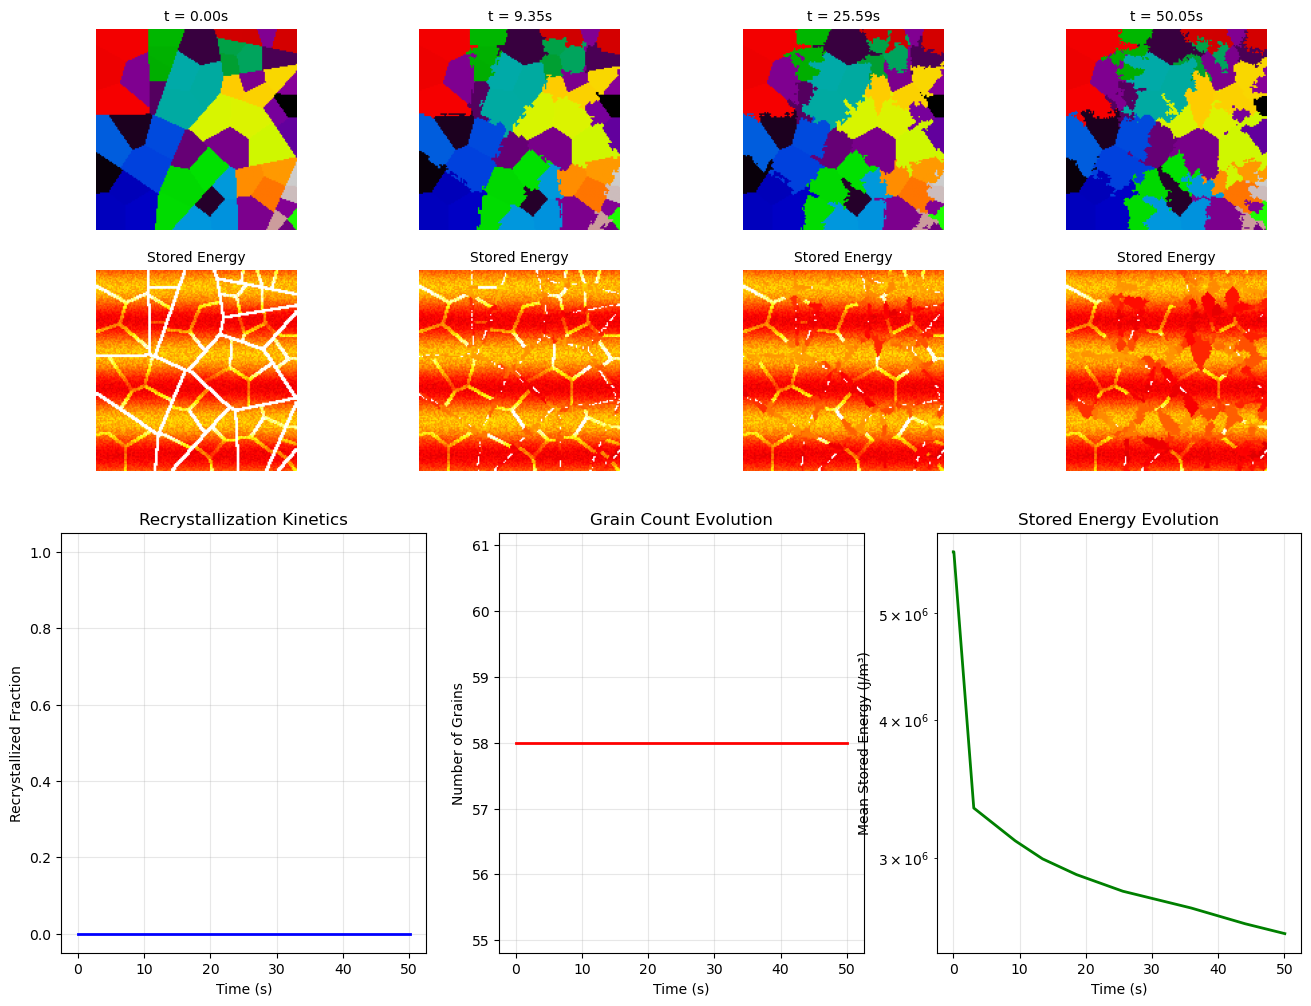

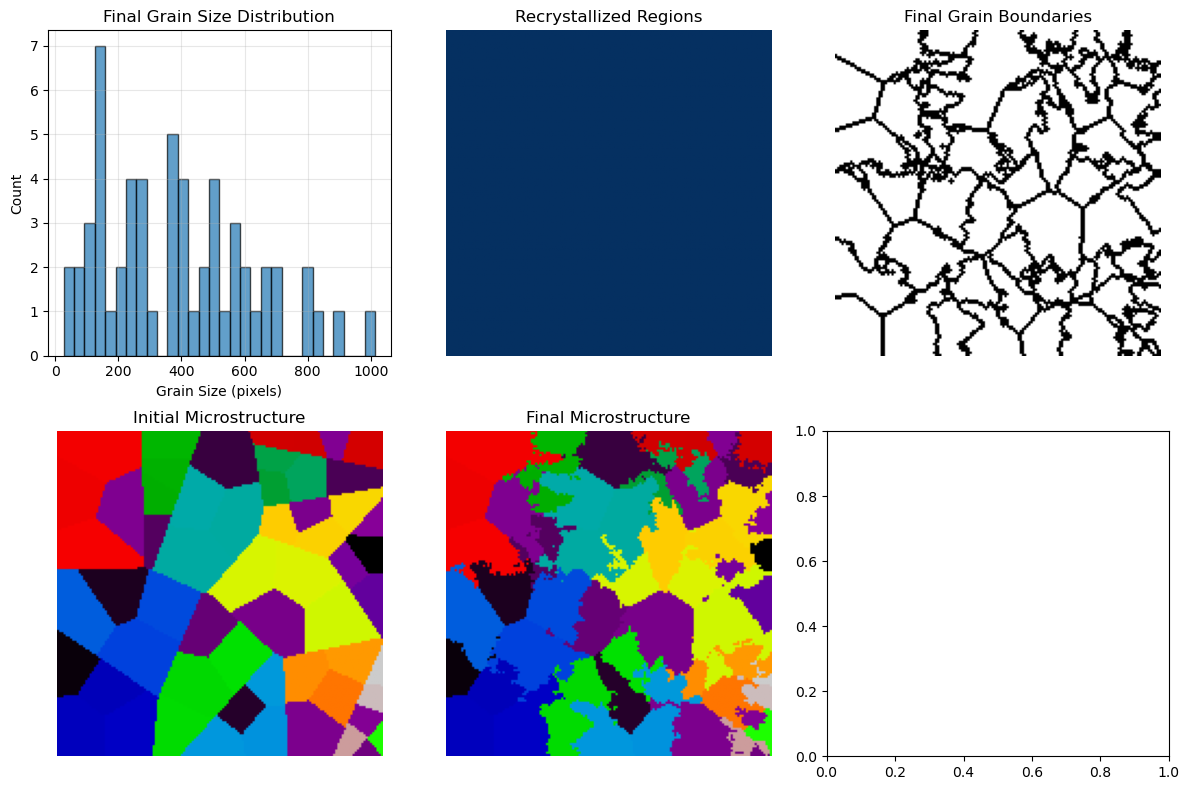

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple, Dict, Set

@dataclass
class CellularAutomatonRexGG:
    """
    Working Cellular Automaton for Recrystallization and Grain Growth
    """
    # Grid parameters
    nx: int = 150
    ny: int = 150
    dx: float = 1e-6  # Cell size in meters
    
    # Material parameters
    grain_boundary_energy: float = 0.5  # J/m^2
    mobility_pre_exponential: float = 1e-4  # m^4/(J·s) - increased for visible kinetics
    activation_energy: float = 140e3  # J/mol
    temperature: float = 873  # K
    R: float = 8.314  # J/(mol·K)
    
    # Misorientation thresholds
    min_misorientation: float = 1.0   # degrees - below this, no boundary
    lagb_threshold: float = 2.0       # degrees - LAGB threshold  
    hagb_threshold: float = 15.0      # degrees - HAGB threshold
    
    # Stored energy parameters
    stored_energy_factor: float = 5e6  # J/m^3 - typical stored energy in deformed metals
    max_kam_degrees: float = 5.0       # Maximum expected KAM in degrees
    
    # Kinetic factor
    beta_factor: float = 0.5  # Grid discretization correction
    
    def __init__(self):
        self.n_cells = self.nx * self.ny
        
        # Microstructure state
        self.orientation_id = np.zeros(self.n_cells, dtype=int)
        self.euler_angles = {}  # orientation_id -> (phi1, Phi, phi2)
        
        # Deformation state
        self.kam = np.zeros(self.n_cells)  # Kernel Average Misorientation in degrees
        self.stored_energy = np.zeros(self.n_cells)  # J/m^3
        
        # Cellular automaton state
        self.consumption_rate = np.zeros(self.n_cells)
        self.consumed_fraction = np.zeros(self.n_cells)
        self.growing_neighbor = -np.ones(self.n_cells, dtype=int)
        
        # Tracking
        self.boundary_cells = set()
        self.is_recrystallized = np.zeros(self.n_cells, dtype=bool)
        
        # Statistics tracking
        self.total_time = 0.0
        self.step_count = 0
        
        # Initialize deformed microstructure
        self._create_deformed_microstructure()
        self._identify_boundary_cells()
        
    def _create_deformed_microstructure(self):
        """Create a deformed microstructure with subgrains and orientation gradients"""
        
        # Create initial grain structure
        n_grains = 15
        grain_centers = np.random.rand(n_grains, 2)
        grain_centers[:, 0] *= self.nx
        grain_centers[:, 1] *= self.ny
        
        # Assign cells to grains using Voronoi tessellation
        for i in range(self.nx):
            for j in range(self.ny):
                cell_idx = i * self.ny + j
                
                # Find nearest grain center
                min_dist = float('inf')
                nearest_grain = 0
                
                for g in range(n_grains):
                    dx = i - grain_centers[g, 0]
                    dy = j - grain_centers[g, 1]
                    dist = dx*dx + dy*dy
                    
                    if dist < min_dist:
                        min_dist = dist
                        nearest_grain = g
                
                self.orientation_id[cell_idx] = nearest_grain
        
        # Generate base orientations
        for g in range(n_grains):
            phi1 = np.random.uniform(0, 360)
            Phi = np.random.uniform(0, 180)
            phi2 = np.random.uniform(0, 360)
            self.euler_angles[g] = (phi1, Phi, phi2)
        
        # Add subgrain structure
        self._add_subgrains(n_grains)
        
        # Calculate KAM
        self._calculate_kam()
        
        # Set stored energy based on deformation heterogeneity
        for cell_idx in range(self.n_cells):
            # Base stored energy from KAM
            normalized_kam = self.kam[cell_idx] / self.max_kam_degrees
            base_energy = self.stored_energy_factor * (0.5 + 0.5 * normalized_kam)
            
            # Add spatial variation (deformation bands)
            i, j = cell_idx // self.ny, cell_idx % self.ny
            band_factor = 1.0 + 0.3 * np.sin(2 * np.pi * i / self.nx * 3)
            
            # Random local variations
            local_factor = np.random.uniform(0.9, 1.1)
            
            self.stored_energy[cell_idx] = base_energy * band_factor * local_factor
        
        # Create recrystallization nuclei
        # Place nuclei at grain boundaries with locally low stored energy
        boundary_cells_list = list(self.boundary_cells)
        if len(boundary_cells_list) > 0:
            # Find cells with below-average stored energy
            mean_energy = np.mean(self.stored_energy)
            potential_sites = [cell for cell in boundary_cells_list 
                             if self.stored_energy[cell] < 0.8 * mean_energy]
            
            if len(potential_sites) > 0:
                # Select a few nucleation sites
                n_rex_nuclei = min(8, max(3, len(potential_sites) // 20))
                rex_sites = np.random.choice(potential_sites, n_rex_nuclei, replace=False)
                
                for site in rex_sites:
                    # Mark as recrystallized
                    self.is_recrystallized[site] = True
                    self.stored_energy[site] = 0.0  # Zero stored energy
                    
                    # Give rex nuclei new orientations
                    new_ori_id = 1000 + site  # Unique ID
                    self.orientation_id[site] = new_ori_id
                    phi1 = np.random.uniform(0, 360)
                    Phi = np.random.uniform(0, 180)
                    phi2 = np.random.uniform(0, 360)
                    self.euler_angles[new_ori_id] = (phi1, Phi, phi2)
                    
                    # Create energy gradient around nuclei
                    for nbr in self._get_all_neighbors(site):
                        if not self.is_recrystallized[nbr]:
                            self.stored_energy[nbr] *= 0.7  # Reduce neighbor energy
    
    def _add_subgrains(self, n_grains):
        """Add subgrain structure to existing grains"""
        subgrain_id_offset = n_grains
        
        for g in range(n_grains):
            grain_cells = np.where(self.orientation_id == g)[0]
            
            if len(grain_cells) < 30:
                continue
            
            # Create 2-4 subgrains per grain
            n_subgrains = min(4, max(2, len(grain_cells) // 50))
            
            # Use k-means like clustering for subgrains
            if n_subgrains > 1:
                # Get cell positions
                positions = []
                for cell in grain_cells:
                    i, j = cell // self.ny, cell % self.ny
                    positions.append([i, j])
                positions = np.array(positions)
                
                # Simple k-means
                centers = positions[np.random.choice(len(positions), n_subgrains, replace=False)]
                
                for iteration in range(5):
                    # Assign cells to nearest center
                    assignments = np.zeros(len(positions), dtype=int)
                    for idx, pos in enumerate(positions):
                        dists = np.sum((centers - pos)**2, axis=1)
                        assignments[idx] = np.argmin(dists)
                    
                    # Update centers
                    for k in range(n_subgrains):
                        cluster_positions = positions[assignments == k]
                        if len(cluster_positions) > 0:
                            centers[k] = np.mean(cluster_positions, axis=0)
                
                # Assign orientations
                for idx, cell in enumerate(grain_cells):
                    if assignments[idx] > 0:  # Keep first subgrain with parent orientation
                        new_ori_id = subgrain_id_offset + g * 10 + assignments[idx]
                        self.orientation_id[cell] = new_ori_id
                        
                        # Create small misorientation from parent
                        if new_ori_id not in self.euler_angles:
                            parent_euler = self.euler_angles[g]
                            delta_phi1 = np.random.uniform(-5, 5)
                            delta_Phi = np.random.uniform(-3, 3)
                            delta_phi2 = np.random.uniform(-5, 5)
                            
                            self.euler_angles[new_ori_id] = (
                                parent_euler[0] + delta_phi1,
                                parent_euler[1] + delta_Phi,
                                parent_euler[2] + delta_phi2
                            )
    
    def _calculate_kam(self):
        """Calculate Kernel Average Misorientation for each cell"""
        for cell_idx in range(self.n_cells):
            neighbors = self._get_all_neighbors(cell_idx)
            
            total_misorientation = 0.0
            n_boundaries = 0
            
            for nbr in neighbors:
                mis = self._calculate_misorientation(
                    self.orientation_id[cell_idx],
                    self.orientation_id[nbr]
                )
                
                if mis > self.min_misorientation:
                    total_misorientation += mis
                    n_boundaries += 1
            
            if n_boundaries > 0:
                self.kam[cell_idx] = total_misorientation / n_boundaries
            else:
                self.kam[cell_idx] = 0.0
    
    def _identify_boundary_cells(self):
        """Identify cells at boundaries"""
        self.boundary_cells.clear()
        
        for cell_idx in range(self.n_cells):
            neighbors = self._get_neighbors(cell_idx)
            
            for nbr in neighbors:
                if self.orientation_id[cell_idx] != self.orientation_id[nbr]:
                    mis = self._calculate_misorientation(
                        self.orientation_id[cell_idx],
                        self.orientation_id[nbr]
                    )
                    if mis > self.min_misorientation:
                        self.boundary_cells.add(cell_idx)
                        break
    
    def _get_neighbors(self, cell_idx: int) -> List[int]:
        """Get Von Neumann neighbors (4-connectivity)"""
        i, j = cell_idx // self.ny, cell_idx % self.ny
        neighbors = []
        
        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni = i + di
            nj = j + dj
            if 0 <= ni < self.nx and 0 <= nj < self.ny:
                neighbors.append(ni * self.ny + nj)
            
        return neighbors
    
    def _get_all_neighbors(self, cell_idx: int) -> List[int]:
        """Get Moore neighbors (8-connectivity)"""
        i, j = cell_idx // self.ny, cell_idx % self.ny
        neighbors = []
        
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                if di == 0 and dj == 0:
                    continue
                ni = i + di
                nj = j + dj
                if 0 <= ni < self.nx and 0 <= nj < self.ny:
                    neighbors.append(ni * self.ny + nj)
                
        return neighbors
    
    def _calculate_misorientation(self, ori_id1: int, ori_id2: int) -> float:
        """Calculate misorientation between two orientations"""
        if ori_id1 == ori_id2:
            return 0.0
            
        euler1 = self.euler_angles.get(ori_id1, (0, 0, 0))
        euler2 = self.euler_angles.get(ori_id2, (0, 0, 0))
        
        # Simplified misorientation calculation
        d_phi1 = abs(euler1[0] - euler2[0])
        d_phi1 = min(d_phi1, 360 - d_phi1)
        
        d_Phi = abs(euler1[1] - euler2[1])
        
        d_phi2 = abs(euler1[2] - euler2[2])
        d_phi2 = min(d_phi2, 360 - d_phi2)
        
        # Approximate misorientation
        mis = np.sqrt(d_phi1**2 + d_Phi**2 + d_phi2**2) / np.sqrt(3)
        
        return min(mis, 62.8)  # Maximum misorientation in cubic symmetry
    
    def _get_boundary_energy(self, misorientation: float) -> float:
        """Read-Shockley model for boundary energy"""
        if misorientation < self.min_misorientation:
            return 0.0
            
        if misorientation >= self.hagb_threshold:
            return self.grain_boundary_energy
            
        # Read-Shockley equation
        theta_m = self.hagb_threshold * np.pi / 180  # Convert to radians
        theta = misorientation * np.pi / 180
        
        return self.grain_boundary_energy * (theta / theta_m) * (1 - np.log(theta / theta_m))
    
    def _get_mobility(self, misorientation: float) -> float:
        """Get boundary mobility with misorientation dependence"""
        if misorientation < self.min_misorientation:
            return 0.0
            
        # Base mobility with Arrhenius temperature dependence
        M0 = self.mobility_pre_exponential * np.exp(-self.activation_energy / (self.R * self.temperature))
        
        if misorientation >= self.hagb_threshold:
            return M0
        else:
            # Reduced mobility for low angle boundaries
            return M0 * (misorientation / self.hagb_threshold) ** 3
    
    def calculate_reorientation_rates(self) -> float:
        """Calculate growth rates for boundary cells"""
        max_rate = 0.0
        
        # Reset
        self.consumption_rate.fill(0.0)
        self.growing_neighbor.fill(-1)
        
        for cell_idx in self.boundary_cells:
            best_rate = 0.0
            best_neighbor = -1
            
            neighbors = self._get_neighbors(cell_idx)
            
            for nbr_idx in neighbors:
                if self.orientation_id[nbr_idx] == self.orientation_id[cell_idx]:
                    continue
                
                # Calculate driving forces
                stored_energy_driving = self.stored_energy[cell_idx] - self.stored_energy[nbr_idx]
                
                # Special case: recrystallized grains can always grow into deformed matrix
                if self.is_recrystallized[nbr_idx] and not self.is_recrystallized[cell_idx]:
                    stored_energy_driving = self.stored_energy[cell_idx]  # Full stored energy as driving force
                elif stored_energy_driving <= 0:
                    continue
                
                # Get boundary properties
                boundary_mis = self._calculate_misorientation(
                    self.orientation_id[cell_idx], 
                    self.orientation_id[nbr_idx]
                )
                mobility = self._get_mobility(boundary_mis)
                
                # Calculate velocity: v = M * P
                velocity = mobility * stored_energy_driving
                
                # Convert to consumption rate
                rate = velocity / self.dx * self.beta_factor
                
                if rate > best_rate:
                    best_rate = rate
                    best_neighbor = nbr_idx
            
            self.consumption_rate[cell_idx] = best_rate
            self.growing_neighbor[cell_idx] = best_neighbor
            max_rate = max(max_rate, best_rate)
        
        return max_rate
    
    def update_microstructure(self, dt: float) -> int:
        """Update cells based on consumption"""
        cells_to_switch = []
        
        # Update consumed fractions
        for cell_idx in self.boundary_cells:
            if self.consumption_rate[cell_idx] > 0:
                self.consumed_fraction[cell_idx] += self.consumption_rate[cell_idx] * dt
                
                if self.consumed_fraction[cell_idx] >= 1.0:
                    cells_to_switch.append(cell_idx)
        
        # Switch cells
        n_switched = 0
        for cell_idx in cells_to_switch:
            nbr_idx = int(self.growing_neighbor[cell_idx])
            if nbr_idx >= 0:
                # Copy orientation
                self.orientation_id[cell_idx] = self.orientation_id[nbr_idx]
                
                # Update properties
                if self.is_recrystallized[nbr_idx]:
                    # Spreading recrystallized grain
                    self.stored_energy[cell_idx] = 0.0
                    self.is_recrystallized[cell_idx] = True
                else:
                    # Normal grain growth - partial recovery
                    self.stored_energy[cell_idx] = self.stored_energy[nbr_idx]
                
                # Reset
                self.consumed_fraction[cell_idx] = 0.0
                n_switched += 1
        
        # Update boundaries
        if n_switched > 0:
            self._identify_boundary_cells()
            # Update KAM periodically (expensive operation)
            if self.step_count % 50 == 0:
                self._calculate_kam()
        
        return n_switched
    
    def simulate_step(self) -> Tuple[float, int]:
        """Perform one simulation step"""
        max_rate = self.calculate_reorientation_rates()
        
        if max_rate < 1e-15:
            return 0.0, 0
        
        # Adaptive time step
        dt = min(0.5 / max_rate, 1.0)  # Safety factor of 0.5
        
        n_switched = self.update_microstructure(dt)
        
        self.total_time += dt
        self.step_count += 1
        
        return dt, n_switched
    
    def get_statistics(self) -> Dict:
        """Get simulation statistics"""
        unique_oris = len(np.unique(self.orientation_id))
        rex_fraction = np.mean(self.is_recrystallized)
        mean_stored_energy = np.mean(self.stored_energy)
        mean_kam = np.mean(self.kam)
        
        # Calculate grain sizes
        unique_grains, grain_sizes = np.unique(self.orientation_id, return_counts=True)
        mean_grain_size = np.mean(grain_sizes) * self.dx * self.dx  # Convert to area
        
        return {
            'n_orientations': unique_oris,
            'rex_fraction': rex_fraction,
            'mean_stored_energy': mean_stored_energy,
            'mean_kam': mean_kam,
            'n_boundaries': len(self.boundary_cells),
            'time': self.total_time,
            'mean_grain_size': mean_grain_size
        }

def run_simulation(max_time: float = 100.0, save_interval: int = 20):
    """Run the simulation with progress tracking"""
    ca = CellularAutomatonRexGG()
    
    # History tracking
    history = {
        'time': [],
        'rex_fraction': [],
        'n_orientations': [],
        'mean_kam': [],
        'mean_stored_energy': [],
        'microstructure': [],
        'stored_energy_map': []
    }
    
    # Store initial state
    stats = ca.get_statistics()
    history['time'].append(0.0)
    history['rex_fraction'].append(stats['rex_fraction'])
    history['n_orientations'].append(stats['n_orientations'])
    history['mean_kam'].append(stats['mean_kam'])
    history['mean_stored_energy'].append(stats['mean_stored_energy'])
    history['microstructure'].append(ca.orientation_id.reshape(ca.nx, ca.ny).copy())
    history['stored_energy_map'].append(ca.stored_energy.reshape(ca.nx, ca.ny).copy())
    
    print(f"Initial state:")
    print(f"  Grains: {stats['n_orientations']}")
    print(f"  Rex fraction: {stats['rex_fraction']:.3f}")
    print(f"  Mean stored energy: {stats['mean_stored_energy']:.2e} J/m³")
    print(f"  Mobility at HAGB: {ca._get_mobility(ca.hagb_threshold):.2e} m⁴/(J·s)")
    print(f"  Number of rex nuclei: {np.sum(ca.is_recrystallized)}")
    print(f"\nStarting simulation...")
    
    # Run simulation
    step = 0
    last_save_step = 0
    no_progress_counter = 0
    last_rex_fraction = stats['rex_fraction']
    
    while ca.total_time < max_time and step < 50000:
        dt, n_switched = ca.simulate_step()
        
        if dt == 0:
            print("\nSteady state reached")
            break
        
        step += 1
        
        # Check for progress
        if step % 100 == 0:
            current_rex = np.mean(ca.is_recrystallized)
            if abs(current_rex - last_rex_fraction) < 1e-6:
                no_progress_counter += 1
                if no_progress_counter > 10:
                    print("\nNo progress detected - stopping")
                    break
            else:
                no_progress_counter = 0
                last_rex_fraction = current_rex
        
        # Save history at intervals
        if step - last_save_step >= save_interval or step == 1:
            stats = ca.get_statistics()
            history['time'].append(ca.total_time)
            history['rex_fraction'].append(stats['rex_fraction'])
            history['n_orientations'].append(stats['n_orientations'])
            history['mean_kam'].append(stats['mean_kam'])
            history['mean_stored_energy'].append(stats['mean_stored_energy'])
            history['microstructure'].append(ca.orientation_id.reshape(ca.nx, ca.ny).copy())
            history['stored_energy_map'].append(ca.stored_energy.reshape(ca.nx, ca.ny).copy())
            
            if step % 100 == 0:
                print(f"Step {step}: t={ca.total_time:.3f}s, "
                      f"Rex={stats['rex_fraction']:.3f}, "
                      f"Grains={stats['n_orientations']}, "
                      f"Switched={n_switched}")
            
            last_save_step = step
    
    # Save final state
    stats = ca.get_statistics()
    history['time'].append(ca.total_time)
    history['rex_fraction'].append(stats['rex_fraction'])
    history['n_orientations'].append(stats['n_orientations'])
    history['mean_kam'].append(stats['mean_kam'])
    history['mean_stored_energy'].append(stats['mean_stored_energy'])
    history['microstructure'].append(ca.orientation_id.reshape(ca.nx, ca.ny).copy())
    history['stored_energy_map'].append(ca.stored_energy.reshape(ca.nx, ca.ny).copy())
    
    print(f"\nSimulation completed:")
    print(f"  Total steps: {step}")
    print(f"  Final time: {ca.total_time:.3f}s")
    print(f"  Final rex fraction: {stats['rex_fraction']:.3f}")
    print(f"  Final number of grains: {stats['n_orientations']}")
    
    return ca, history

def visualize_results(ca, history):
    """Enhanced visualization of results"""
    fig = plt.figure(figsize=(16, 12))
    
    # Select time points to show
    n_snapshots = len(history['microstructure'])
    if n_snapshots >= 4:
        indices = [0, n_snapshots//3, 2*n_snapshots//3, n_snapshots-1]
    else:
        indices = list(range(n_snapshots))
    
    # Row 1: Microstructure evolution
    for i, idx in enumerate(indices):
        ax = plt.subplot(4, 4, i+1)
        im = ax.imshow(history['microstructure'][idx], cmap='nipy_spectral')
        ax.set_title(f"t = {history['time'][idx]:.2f}s", fontsize=10)
        ax.axis('off')
    
    # Row 2: Stored energy evolution
    for i, idx in enumerate(indices):
        ax = plt.subplot(4, 4, i+5)
        im = ax.imshow(history['stored_energy_map'][idx], cmap='hot', 
                      vmin=0, vmax=ca.stored_energy_factor)
        ax.set_title(f"Stored Energy", fontsize=10)
        ax.axis('off')
    
    # Recrystallization kinetics
    ax = plt.subplot(2, 3, 4)
    ax.plot(history['time'], history['rex_fraction'], 'b-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Recrystallized Fraction')
    ax.set_title('Recrystallization Kinetics')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-0.05, 1.05)
    
    # Grain count evolution
    ax = plt.subplot(2, 3, 5)
    ax.plot(history['time'], history['n_orientations'], 'r-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Number of Grains')
    ax.set_title('Grain Count Evolution')
    ax.grid(True, alpha=0.3)
    
    # Stored energy evolution
    ax = plt.subplot(2, 3, 6)
    ax.semilogy(history['time'], history['mean_stored_energy'], 'g-', linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean Stored Energy (J/m³)')
    ax.set_title('Stored Energy Evolution')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis figure
    fig2, axes = plt.subplots(2, 3, figsize=(12, 8))
    
    # Final grain size distribution
    final_micro = history['microstructure'][-1]
    unique_grains, grain_sizes = np.unique(final_micro, return_counts=True)
    
    axes[0, 0].hist(grain_sizes, bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Grain Size (pixels)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Final Grain Size Distribution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Rex regions
    axes[0, 1].imshow(ca.is_recrystallized.reshape(ca.nx, ca.ny), cmap='RdBu_r')
    axes[0, 1].set_title('Recrystallized Regions')
    axes[0, 1].axis('off')
    
    # Final boundaries
    boundary_map = np.zeros((ca.nx, ca.ny))
    for cell in ca.boundary_cells:
        i, j = cell // ca.ny, cell % ca.ny
        boundary_map[i, j] = 1
    
    axes[0, 2].imshow(boundary_map, cmap='gray_r')
    axes[0, 2].set_title('Final Grain Boundaries')
    axes[0, 2].axis('off')
    
    # Initial vs final microstructure
    axes[1, 0].imshow(history['microstructure'][0], cmap='nipy_spectral')
    axes[1, 0].set_title('Initial Microstructure')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(history['microstructure'][-1], cmap='nipy_spectral')
    axes[1, 1].set_title('Final Microstructure')
    axes[1, 1].axis('off')
    
    # JMAK plot
    if len(history['rex_fraction']) > 2 and max(history['rex_fraction']) > 0.01:
        rex_frac = np.array(history['rex_fraction'])
        time = np.array(history['time'])
        
        # Filter valid values for JMAK
        valid = (rex_frac > 0.01) & (rex_frac < 0.99)
        if np.sum(valid) > 2:
            ln_ln = np.log(-np.log(1 - rex_frac[valid]))
            ln_t = np.log(time[valid])
            
            # Linear fit
            coeffs = np.polyfit(ln_t, ln_ln, 1)
            fit_line = coeffs[0] * ln_t + coeffs[1]
            
            axes[1, 2].plot(ln_t, ln_ln, 'bo', label='Data')
            axes[1, 2].plot(ln_t, fit_line, 'r-', label=f'n={coeffs[0]:.2f}')
            axes[1, 2].set_xlabel('ln(t)')
            axes[1, 2].set_ylabel('ln(-ln(1-X))')
            axes[1, 2].set_title('JMAK Plot')
            axes[1, 2].legend()
            axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run with more reasonable parameters
    ca, history = run_simulation(max_time=50.0, save_interval=50)
    visualize_results(ca, history)